In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_parquet('train-00000-of-00001-daf190ce720b3dbb.parquet', engine='pyarrow')
test = pd.read_parquet('test-00000-of-00001-fa9b3e8ade89a333.parquet', engine='pyarrow')
df = pd.concat([train, test], ignore_index=True)
df

,text,label
0,hey I am looking for Xray baggage datasets can...,not_spam
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam
4,Trying to see if anyone already has timestamps...,not_spam
...,...,...
10895,Is it good and usable?\n\n[https://www.uscompa...,not_spam
10896,I'm not sure if this is the absolute best sub ...,not_spam
10897,Would love if anyone knew of any really good d...,not_spam
10898,"Fields = Hashrate, VRAM, TDP, MSRP, Profit/day",not_spam


In [5]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10900 non-null  object
 1   label   10900 non-null  object
dtypes: object(2)
memory usage: 170.4+ KB


,text,label
count,10900,10900
unique,10662,2
top,"Show off, complain, and generally have a chat ...",spam
freq,14,5500


In [6]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10662 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10662 non-null  object
 1   label   10662 non-null  object
dtypes: object(2)
memory usage: 249.9+ KB


In [7]:
df['label'].value_counts()

label
spam        5500
not_spam    5162
Name: count, dtype: int64

# EDA

In [1]:
from wordcloud import WordCloud
from collections import Counter
import nltk
import string

nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/eatlunches/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df_eda = df
df_eda['label'] = df['label'].astype(str).str.lower().map({'not_spam': 0, 'spam': 1})
df_eda = df_eda.dropna(subset=['text', 'label'])

df_eda['message_length'] = df_eda['text'].apply(lambda x: len(str(x)))

/tmp/ipykernel_32737/1615878895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['label'] = df['label'].astype(str).str.lower().map({'not_spam': 0, 'spam': 1})


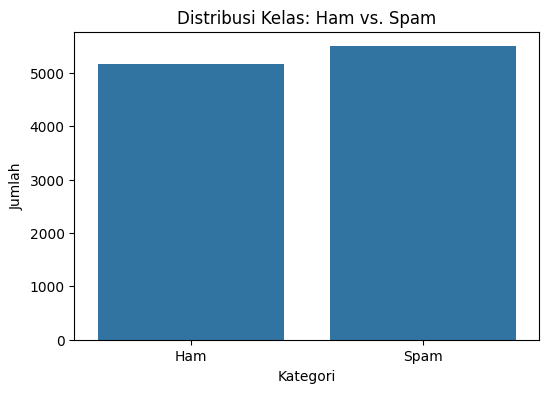

In [9]:
# Analyze class distribution (spam vs. ham).
if not df_eda.empty:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='label')
    plt.xticks([0, 1], ['Ham', 'Spam'])
    plt.title('Distribusi Kelas: Ham vs. Spam')
    plt.xlabel('Kategori')
    plt.ylabel('Jumlah')
    plt.show()
else:
    print("Data kosong, tidak bisa menampilkan distribusi kelas.")

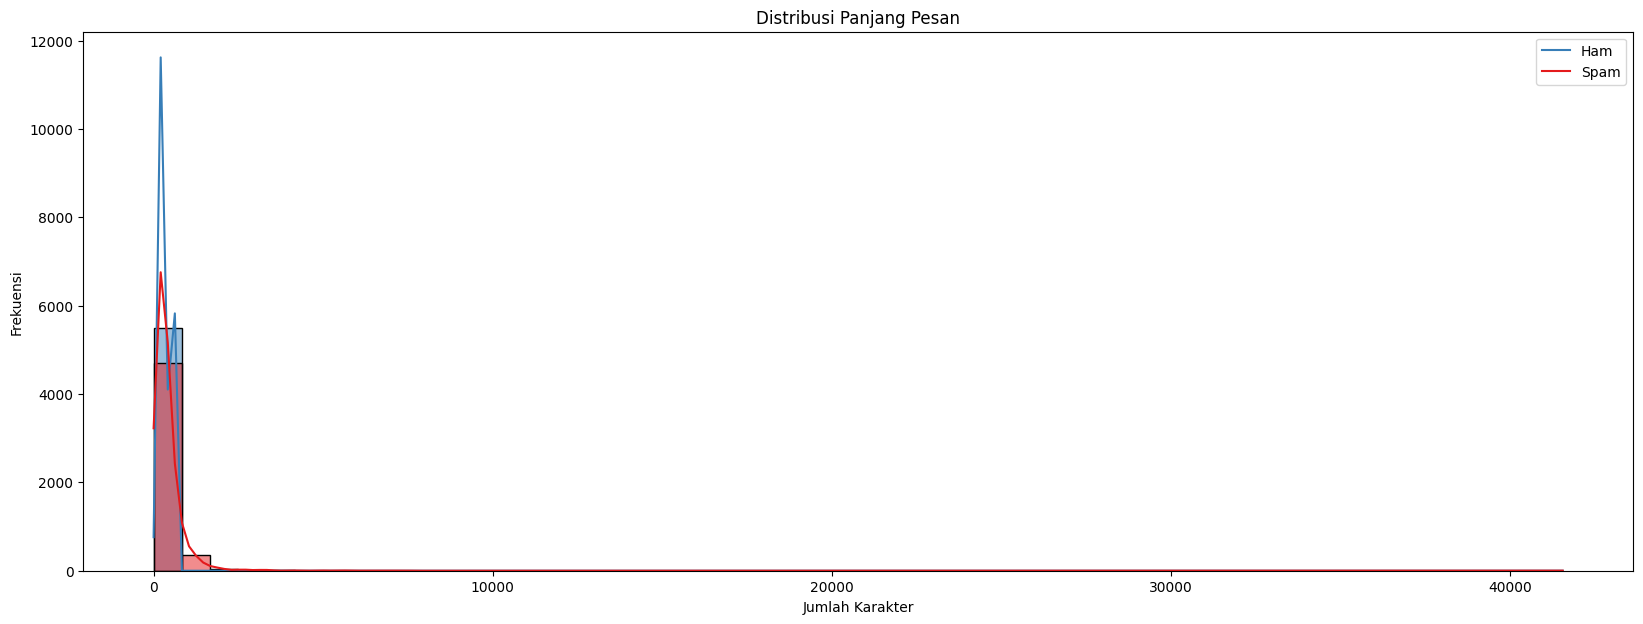

In [19]:
# Message length
if not df_eda.empty and df_eda['message_length'].notnull().sum() > 0:
    plt.figure(figsize=(20, 7))
    if df_eda['message_length'].nunique() > 1:
        sns.histplot(data=df_eda, x='message_length', hue='label', bins=50, kde=True, palette='Set1')
    else:
        sns.histplot(data=df_eda, x='message_length', hue='label', bins=50, kde=False, palette='Set1')
    plt.title('Distribusi Panjang Pesan')
    plt.xlabel('Jumlah Karakter')
    plt.ylabel('Frekuensi')
    plt.legend(labels=['Ham', 'Spam'])
    plt.show()
else:
    print("Data tidak cukup untuk histogram panjang pesan.")

/tmp/ipykernel_32737/1913200577.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='viridis')


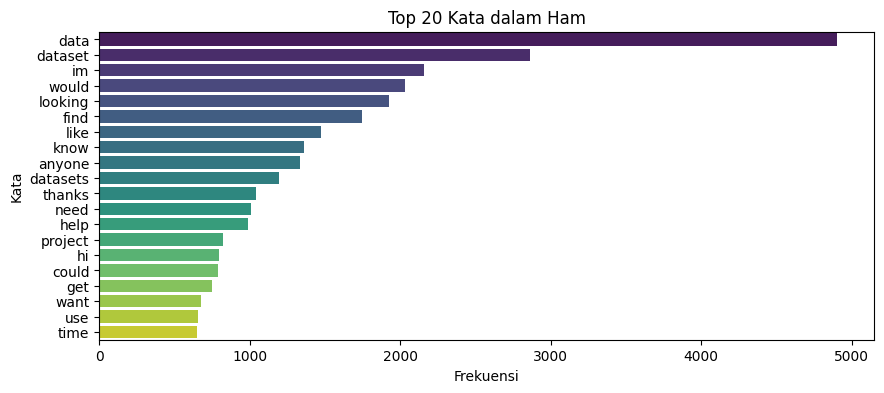

/tmp/ipykernel_32737/1913200577.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(freqs), y=list(words), palette='viridis')


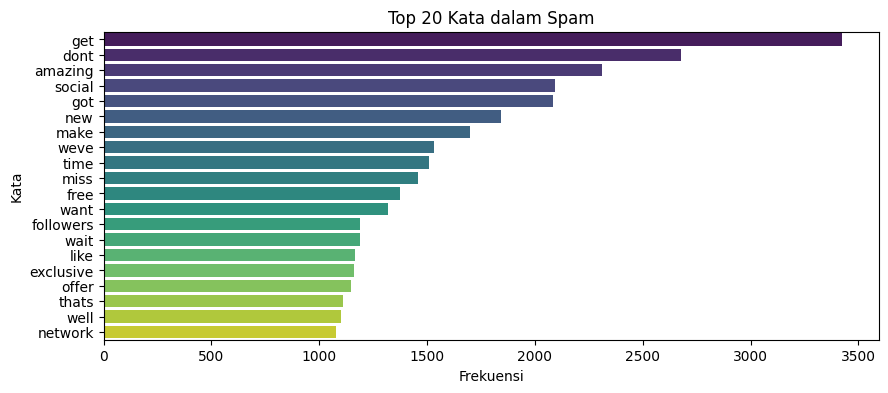

In [11]:
# Most frequent words (spam vs. ham)
def get_top_words(messages, n=20):
    stop_words = set(stopwords.words('english'))
    words = ' '.join(messages).lower()
    words = words.translate(str.maketrans('', '', string.punctuation))
    tokens = words.split()
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return Counter(tokens).most_common(n)

top_ham_words = get_top_words(df_eda[df_eda['label'] == 0]['text']) if not df_eda[df_eda['label'] == 0].empty else []
top_spam_words = get_top_words(df_eda[df_eda['label'] == 1]['text']) if not df_eda[df_eda['label'] == 1].empty else []

def plot_top_words(word_freq, title):
    if not word_freq:
        print(f"Tidak ada kata yang bisa ditampilkan untuk: {title}")
        return
    words, freqs = zip(*word_freq)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(freqs), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel('Frekuensi')
    plt.ylabel('Kata')
    plt.show()

plot_top_words(top_ham_words, 'Top 20 Kata dalam Ham')
plot_top_words(top_spam_words, 'Top 20 Kata dalam Spam')

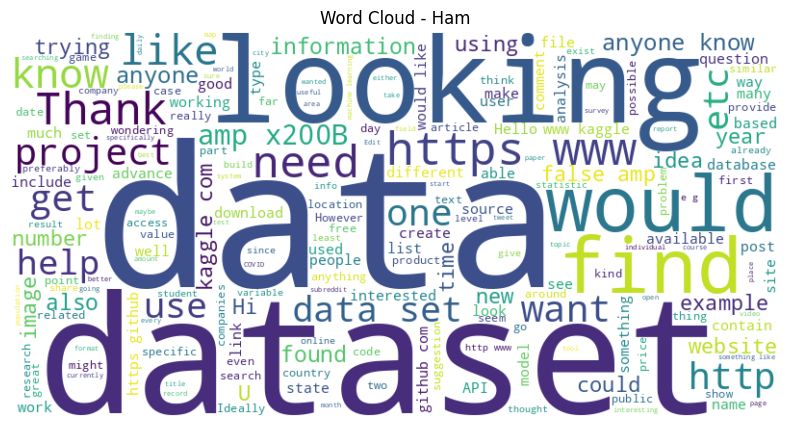

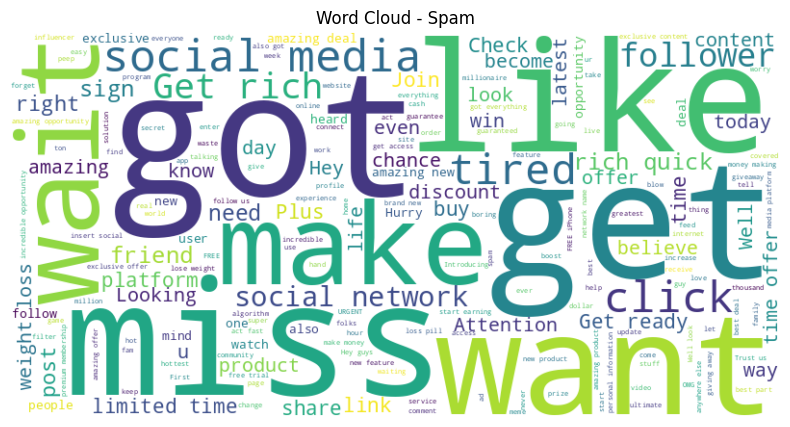

In [13]:
# Word clouds
def generate_wordcloud(messages, title):
    text = ' '.join(messages)
    if not text.strip():
        print(f"Tidak ada teks untuk Word Cloud: {title}")
        return
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          stopwords=stopwords.words('english')).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

if not df_eda[df_eda['label'] == 0].empty:
    generate_wordcloud(df_eda[df_eda['label'] == 0]['text'], 'Word Cloud - Ham')
else:
    print("Tidak ada data untuk Word Cloud Ham.")

if not df_eda[df_eda['label'] == 1].empty:
    generate_wordcloud(df_eda[df_eda['label'] == 1]['text'], 'Word Cloud - Spam')
else:
    print("Tidak ada data untuk Word Cloud Spam.")

# Insight yang didapatkan dari EDA
**Distribusi Label**:

  * Dataset relatif seimbang antara pesan *spam* dan *not_spam*, cocok untuk tugas klasifikasi binary berbasis supervised learning.
  * Keseimbangan ini membantu meminimalkan bias akibat dominasi satu kelas.

**Panjang Pesan**:

  * Sebagian besar pesan (baik spam maupun not_spam) memiliki panjang karakter di bawah 500.
  * Pesan *spam* cenderung lebih panjang dengan beberapa outlier yang mencapai puluhan ribu karakter.
  * Pesan *not_spam* umumnya lebih ringkas, mencerminkan gaya komunikasi langsung ke tujuan.

**Analisis Frekuensi Kata (Not\_Spam)**:

  * Kata-kata yang paling sering muncul:

    * data
    * dataset
    * looking
    * project
  * Mengindikasikan bahwa banyak pesan non-spam berkaitan dengan penelusuran informasi, permintaan bantuan, atau kolaborasi profesional.

**Analisis Frekuensi Kata (Spam)**:

  * Kata-kata dominan dalam pesan spam:

    * get
    * amazing
    * followers
    * offer
    * Clickbait dan kosakata persuasif lainnya.
  * Menggambarkan sifat promosi, ajakan, dan urgensi pada pesan spam.

**Visualisasi Word Cloud**:

  * Word Cloud *not_spam* menampilkan istilah teknis dan sopan (misalnya: “data”, “help”, “project”).
  * Word Cloud *spam* menonjolkan kata-kata mendesak, sensasional, dan bersifat marketing (misalnya: “amazing”, “get”, “followers”).

**Kesimpulan**:

Perbedaan pola kata dan panjang teks antara spam dan not_spam dapat menjadi fitur penting saat merancang model deteksi spam yang efektif.

# Feature Engineering

In [14]:
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [15]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

X = df['text'].apply(clean_text)

le = LabelEncoder()
y = le.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['label']
)

In [16]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [18]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_vec, y_train)

# Predict
y_pred = clf.predict(X_test_vec)

# Evaluation
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9957805907172996
F1 Score:  0.9958997722095672
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1033
           1       1.00      0.99      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1031    2]
 [   7 1093]]


In [28]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_vec, y_train)
y_pred_xgb = xgb_model.predict(X_test_vec)

print("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("F1 Score: ", f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:01:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.993905297702766
F1 Score:  0.9940720474236207
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1033
           1       1.00      0.99      0.99      1100

    accuracy                           0.99      2133
   macro avg       0.99      0.99      0.99      2133
weighted avg       0.99      0.99      0.99      2133

[[1030    3]
 [  10 1090]]


In [12]:
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)

print("Accuracy: ", accuracy_score(y_test, y_pred_nb))
print("F1 Score: ", f1_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))

Accuracy:  0.9948429442100328
F1 Score:  0.9950203712086917
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1033
           1       0.99      1.00      1.00      1100

    accuracy                           0.99      2133
   macro avg       1.00      0.99      0.99      2133
weighted avg       0.99      0.99      0.99      2133

[[1023   10]
 [   1 1099]]


# Cross Validation

In [13]:
from sklearn.model_selection import cross_val_score

In [39]:
scores = cross_val_score(RandomForestClassifier(), X_train_vec, y_train, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy:", (scores.mean()))

Random Forest CV Accuracy: 0.9940204831661928


In [40]:
scores = cross_val_score(XGBClassifier(), X_train_vec, y_train, cv=5, scoring='accuracy')
print("XGBoost Accuracy:", (scores.mean()))

XGBoost Accuracy: 0.9909719362058356


Exception ignored in: <function ResourceTracker.__del__ at 0x7ff3f7049300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fe92a359300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f504ae51300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip

In [14]:
scores = cross_val_score(MultinomialNB(), X_train_vec, y_train, cv=5, scoring='accuracy')
print("Naive Bayes Accuracy:", (scores.mean()))

Naive Bayes Accuracy: 0.9951932286599305


# Tuning

In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [33]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Grid search
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_vec, y_train)

# Best model
print("Best RF Parameters:", rf_grid.best_params_)
print("Best RF Score:", rf_grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best RF Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best RF Score: 0.9950757203315537


In [34]:
y_pred_rf = rf_grid.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9948429442100328
F1 Score:  0.99498861047836
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1033
           1       1.00      0.99      0.99      1100

    accuracy                           0.99      2133
   macro avg       0.99      0.99      0.99      2133
weighted avg       0.99      0.99      0.99      2133

[[1030    3]
 [   8 1092]]


In [35]:
# Parameter grid
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Randomized search
xgb_random = RandomizedSearchCV(xgb, xgb_params, n_iter=50, cv=5,
                                verbose=1, random_state=42, n_jobs=-1, scoring='accuracy')
xgb_random.fit(X_train_vec, y_train)

# Best model
print("Best XGB Parameters:", xgb_random.best_params_)
print("Best XGB Score:", xgb_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:04:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:04:14] WARNING: /workspace/src/learner.cc:738: 
Paramet

Best XGB Parameters: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best XGB Score: 0.9914408693828578


In [36]:
# Evaluate
y_pred_xgb = xgb_random.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("F1 Score: ", f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

Accuracy:  0.9929676511954993
F1 Score:  0.9931662870159453
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1033
           1       1.00      0.99      0.99      1100

    accuracy                           0.99      2133
   macro avg       0.99      0.99      0.99      2133
weighted avg       0.99      0.99      0.99      2133

[[1028    5]
 [  10 1090]]


In [17]:
# Parameter grid
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0]
}

grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_vec, y_train)

# Results
print("Best parameter:", grid.best_params_)
print("Best Naive Bayes score:", grid.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Best parameter: {'alpha': 1.0}
Best Naive Bayes score: 0.9951932286599305


In [18]:
# Evaluate
y_pred_nb = grid.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_nb))
print("F1 Score: ", f1_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))

Accuracy:  0.9948429442100328
F1 Score:  0.9950203712086917
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1033
           1       0.99      1.00      1.00      1100

    accuracy                           0.99      2133
   macro avg       1.00      0.99      0.99      2133
weighted avg       0.99      0.99      0.99      2133

[[1023   10]
 [   1 1099]]


# Save

In [20]:
import joblib

In [ ]:
joblib.dump(rf_grid, 'random_forest_model.pkl')
joblib.dump(xgb_random, 'xgboost_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
joblib.dump(grid, 'naivebayes_model.pkl')

['naivebayes_model.pkl']

Exception ignored in: <function ResourceTracker.__del__ at 0x7f150e751300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f573ba45300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fb961251300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip